In [ ]:
%pip install tensorflow
%pip install python3-distutils


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("data_preprocessed.csv")  # Ensure correct file path

# Define Features and Target
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = df[feature_cols]
y = df['treatment']

# Encode Target Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)  # For DNN

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardizing (Only for DNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Train RF Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)  # Needed for ROC-AUC in multi-class

# Get unique class labels
unique_classes = np.unique(y_test)

# Convert y_test to one-hot encoded format
y_test_binarized = label_binarize(y_test, classes=unique_classes)

# Check if y_test contains more than one class
if y_test_binarized.shape[1] < 2:
    print("Warning: Only one class found in y_test. ROC-AUC cannot be computed.")
    rf_roc_auc = None
else:
    # Compute ROC-AUC Score correctly for multi-class
    rf_roc_auc = roc_auc_score(y_test_binarized, y_pred_rf_proba, multi_class="ovr", average="macro")

# Evaluation
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
if rf_roc_auc is not None:
    print("ROC-AUC Score:", rf_roc_auc)
else:
    print("ROC-AUC could not be computed due to single class in y_test.")


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       120
           1       0.76      0.80      0.78       132

    accuracy                           0.77       252
   macro avg       0.77      0.76      0.76       252
weighted avg       0.77      0.77      0.77       252

Accuracy: 0.7658730158730159
ROC-AUC could not be computed due to single class in y_test.


In [15]:
%pip install keras-callbacks


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement keras-callbacks (from versions: none)
ERROR: No matching distribution found for keras-callbacks

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define Improved DNN Model
dnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_onehot.shape[1], activation='softmax')
])


# Reset Learning Rate to `1e-3`
optimizer = Adam(learning_rate=1e-3)

# Compile Model (Remove ReduceLROnPlateau)
dnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model (Batch Size Increased to `16`)
history = dnn_model.fit(
    X_train_scaled, y_onehot[:len(X_train)], 
    epochs=2000, batch_size=8, validation_split=0.2
)

# Predictions
y_pred_dnn = np.argmax(dnn_model.predict(X_test_scaled), axis=1)

# Evaluation
print("DNN Performance:")
print(classification_report(y_test, y_pred_dnn))
print("Accuracy:", accuracy_score(y_test, y_pred_dnn))


Epoch 1/2000


c:\Users\mohammad mujahiddin\Downloads\Project\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4878 - loss: 0.7213 - val_accuracy: 0.5075 - val_loss: 0.7077
Epoch 2/2000
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5197 - loss: 0.6908 - val_accuracy: 0.4826 - val_loss: 0.7107
Epoch 3/2000
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5635 - loss: 0.6768 - val_accuracy: 0.4378 - val_loss: 0.7103
Epoch 4/2000
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5823 - loss: 0.6745 - val_accuracy: 0.4876 - val_loss: 0.7186
Epoch 5/2000
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5909 - loss: 0.6773 - val_accuracy: 0.4527 - val_loss: 0.7234
Epoch 6/2000
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5871 - loss: 0.6729 - val_accuracy: 0.4527 - val_loss: 0.7269
Epoch 7/2000
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6140 - loss: 0.6631 - val_accuracy: 0.4328 - val_loss: 0.7311
Epoch 8/2000
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6329 - loss: 0.6523 - val_accuracy:

In [5]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7857142857142857


In [9]:
%pip install transformers torch datasets



  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/bd/40/902c95a2a6f5d2d120c940ac4bd1f937c01035af529803c13d65ca33c2d1/transformers-4.48.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     --------- ------------------------------ 10.2/44.4 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.4 kB 162.5 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/44.4 kB 163.8 kB/s eta 0:00:01
     -------------------------------------- 44.4/44.4 kB 198.5 kB/s eta 0:00:00
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/18/cf/ae99bd066571656185be0d88ee70abc58467b76f2f7c8bfeb48735a71fe6/torch-2.6.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/d7/84/0df6c5981f5fc722381662ff8cfbdf8aad64bec875f75d80b55bfef394ce/datasets-3.2.0-py3-none-any.whl.metadata


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define features and target
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = df[feature_cols]
y = df['treatment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [14]:
import joblib

rf_model = joblib.load("random_forest_model.pkl")  # Load saved Random Forest model


In [ ]:
%pip install tf-keras


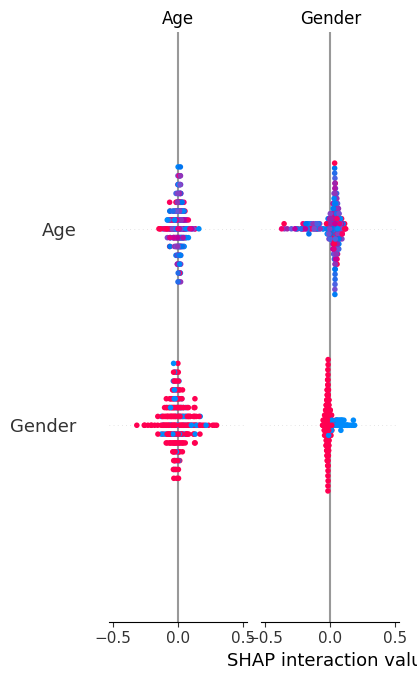

In [17]:
import shap

# Ensure SHAP explainer works with Random Forest
explainer_rf = shap.TreeExplainer(rf_model)  # Use TreeExplainer for tree-based models
shap_values_rf = explainer_rf.shap_values(X_test)  # Get SHAP values

# Generate SHAP Summary Plot
shap.summary_plot(shap_values_rf, X_test)


In [18]:
import joblib

# Save RF Model
joblib.dump(rf_model, "random_forest_model.pkl")

# Save DNN Model
dnn_model.save("dnn_model.h5")

# Save Scaler & Label Encoder
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [19]:
from sklearn.linear_model import LogisticRegression
import joblib

# Train Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Save Logistic Regression Model
joblib.dump(lr_model, "logistic_regression_model.pkl")


['logistic_regression_model.pkl']